# 1. mount Google Drive

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Install and Import Packages

In [28]:
# install tensorflow
!pip install tensorflow
!pip install librosa==0.9.1
# install version 3.5.2 to enable subplots
!pip install matplotlib==3.5.2 --user

# import modules needed
import sys
import tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot

%matplotlib inline
from matplotlib import pyplot
from warnings import simplefilter # import warnings filter
from tensorflow.python.client import device_lib # check for GPU availability

# import modules needed for audio processing
import librosa
import librosa.display
import IPython.display as ipd
#import modules for file names
import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# imports for feature transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical

simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings
print("User Current Version:-", sys.version)
print(device_lib.list_local_devices())

matplotlib.__version__
# check if matplotlib downgraded to 3.5 to enable subplots

print(librosa.__version__)

User Current Version:- 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7579734826815655650
xla_global_id: -1
]
0.9.1


# 3. Import Dataset and Slicing

In [29]:
# Dataset details
# 264 recordings from 88 species
# using pandas read the

birdsong = pd.read_csv('/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/birdsong_metadata.csv')
birdsong = birdsong[["file_id", "english_cname"]] # only select 2 columns
birdsong

# add the csv data to a dictionary, get the file_id as "keys" and the "english_cname" or the bird name as it's values
bird = birdsong.to_dict()
ids=list(bird['file_id'].values())
print('Number of instances: ',len(ids))
bird_name =list(bird['english_cname'].values())

import re
dataset = []

for filename in glob.iglob('/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/*.flac'):
    if filename.endswith('.flac'):
        # remove the dir of file and extract the id
        identity = filename.split('/')[-1][:-5]

        # extract the number
        match = re.search(r'\d+', identity)
        if match:
            identity_num = int(match.group())
            if identity_num in ids:
                index = ids.index(identity_num)
                label = bird_name[index]
                duration = librosa.get_duration(filename=filename)

                if duration >= 5:
                    slice_size = 5
                    iterations = int((duration - slice_size) / (slice_size - 1)) + 1
                    initial_offset = (duration - ((iterations * (slice_size - 1)) + 1)) / 2

                    for i in range(iterations):
                        offset = initial_offset + i * (slice_size - 1)
                        dataset.append({"filename": filename, "label": label, "offset": offset})


Number of instances:  264


# 4. Information of Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1096 non-null   object 
 1   label     1096 non-null   object 
 2   offset    1096 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.8+ KB


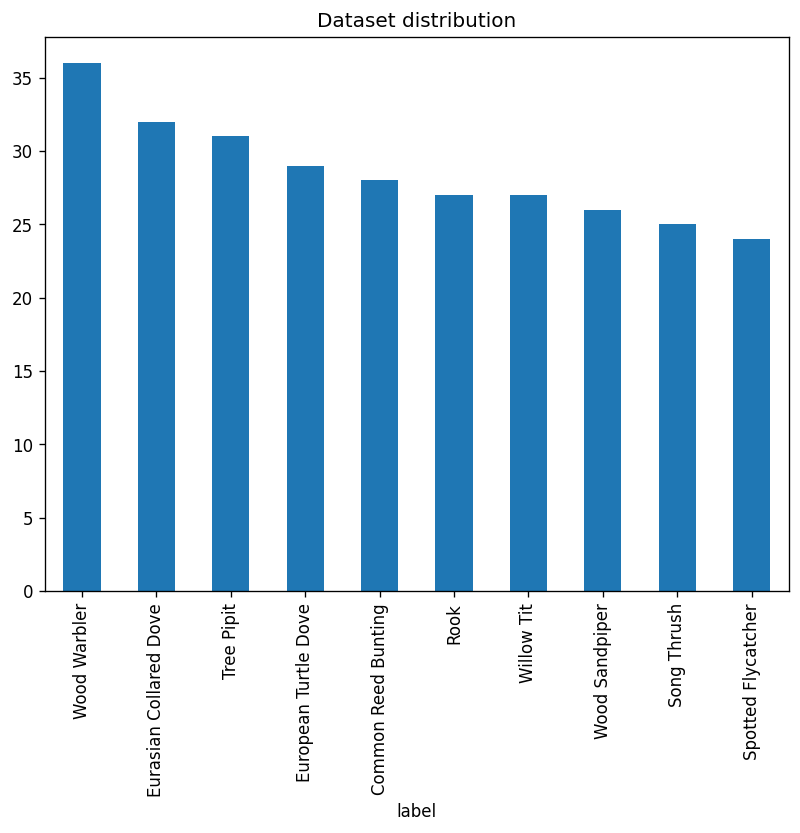

Train: 228
Test: 57


In [30]:
dataset = pd.DataFrame(dataset)
dataset.info()

# the sliced recordings offset values for each bird type as label,
# offset values and correspoding filename displayed
dataset = dataset[dataset['label'].isin(list(dataset.label.value_counts()[:10].index))]
dataset.head(20)

# display the number of recording samples from the dataset per bird type of the total 10
dataset.label.value_counts()

# display the graph with the dataset distribution
# show the bird names on the x-axis and the number of recordings per bird on the y-axis
pyplot.figure(figsize=(8,6), dpi=120)
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

# Split the data into training and test samples, 80% for training and 20% for testing
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

# 5. Features of Data

/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc101934.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc101941.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc102868.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc103145.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc102048.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc143002.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc144991.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc146756.flac
/content/drive/MyDrive/thesis/example/Bird-call-classifier-main/Bird-call-classifier-main/dataset/xc1649

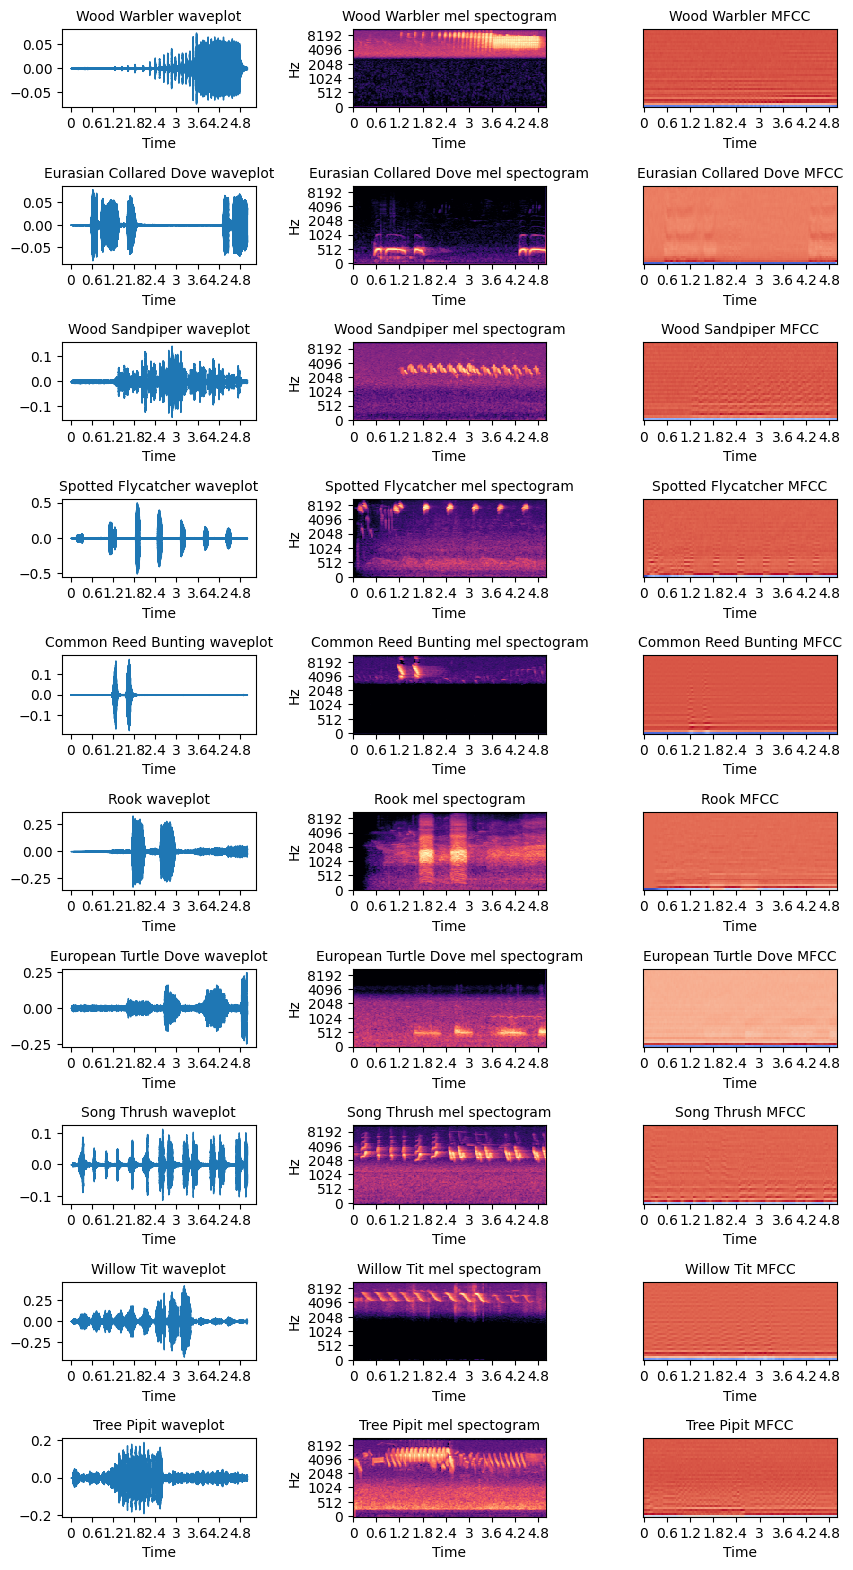

In [31]:
# display the wave plot, mel spectograms and MFCC's for each of the 10 bird types
plt.figure(figsize=(10,60))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[1], duration=5)
    print(dataset[dataset.label==label].filename.iloc[1])

    # Wave plot
    idx+=1
    plt.subplot(30, 3, idx)
    plt.title("%s waveplot" % label,fontsize=10)
    librosa.display.waveshow(y, sr=sr)

    # Mel Spectrogram
    idx+=1
    plt.subplot(30, 3, idx)
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectogram" % label,fontsize=10)

    # MFCC
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(30, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s MFCC" % label,fontsize=10)
plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

# 6. Preprocessing of Data

In [32]:
# Extract mfcc features for each of the processed audio recordings
def extract_features(audio_path,offset):
    y, sr = librosa.load(audio_path, offset=offset, duration=5)
    # function is used to compute the Mel-spectrogram using librosa
    S = librosa.feature.melspectrogram(y, sr=sr,
                                       n_fft=2048,
                                       hop_length=512,
                                       n_mels=128)
    #next extarct the MFCC's
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S),
                                 n_mfcc=40)
    return mfccs

x_train = []
x_test = []

# append the extracted features extracted for each recording from the "train" and "test" datasets
# into testing and training arrays

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))

x_test = (np.asarray(x_test))
x_train = (np.asarray(x_train))

print()

print("X train:", train.shape)
print("X test:", test.shape)

# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train),y= y_train)

# x and y train and test shapes before reshaping
print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y train shape:", y_test.shape)

# reshaping
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# x and y train and test shapes after reshaping
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

100%|██████████| 57/57 [00:13<00:00,  4.27it/s]


X train: (228, 3)
X test: (57, 3)
X train shape: (228, 40, 216)
Y train shape: (228,)
X test shape: (57, 40, 216)
Y train shape: (57,)
X train: (228, 40, 216, 1)
Y train: (228, 10)
X test: (57, 40, 216, 1)
Y test: (57, 10)


# 7. Define CNN model

In [33]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

# CNN MODEL
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))

# PROVIDES MODEL SUMMARY
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 39, 215, 16)         │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 19, 107, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 19, 107, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 18, 106, 32)         │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 53, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 9, 53, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 52, 64)           │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 26, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 26, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 25, 128)          │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 12, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1, 12, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,602 (174.23 KB)

 Trainable params: 44,602 (174.23 KB)

 Non-trainable params: 0 (0.00 B)

# 8. Training

In [35]:
# using adam optimizer with learning rate(lr) 10^-3
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
# compile model using categorical crossentropy, adam optimizer with lr 10^-3 and metrics for measuring results as "accuray"
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Train the model in 32 batches and for 50 epochs
from datetime import datetime
start = datetime.now()

history = model.fit(x_train, y_train,
              batch_size=32,
              epochs=50,
              validation_data=(x_test, y_test),
              shuffle=True)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.0969 - loss: 10.8394 - val_accuracy: 0.2281 - val_loss: 2.0705
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - accuracy: 0.2004 - loss: 3.9365 - val_accuracy: 0.2456 - val_loss: 2.1161
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.2459 - loss: 2.7499 - val_accuracy: 0.4035 - val_loss: 1.7716
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.2607 - loss: 1.9185 - val_accuracy: 0.3684 - val_loss: 1.7072
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4181 - loss: 1.5248 - val_accuracy: 0.4737 - val_loss: 1.6020
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5200 - loss: 1.3549 - val_accuracy: 0.5789 - val_loss: 1.4982
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.5929 - loss: 1.1844 - val_accuracy: 0.6316 - val_loss: 1.3479
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6947 - loss: 0.9615 - val_accuracy: 0.7368 - val_loss

# 9. Results

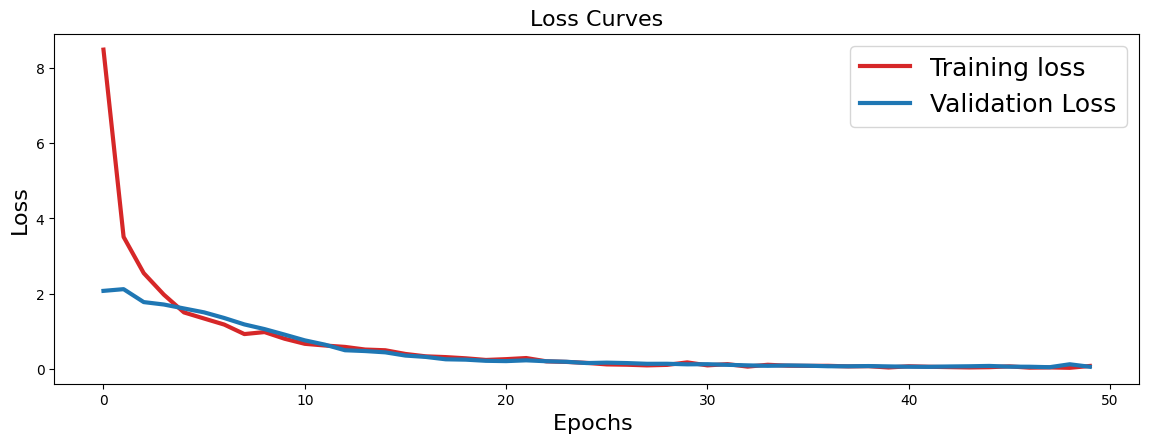

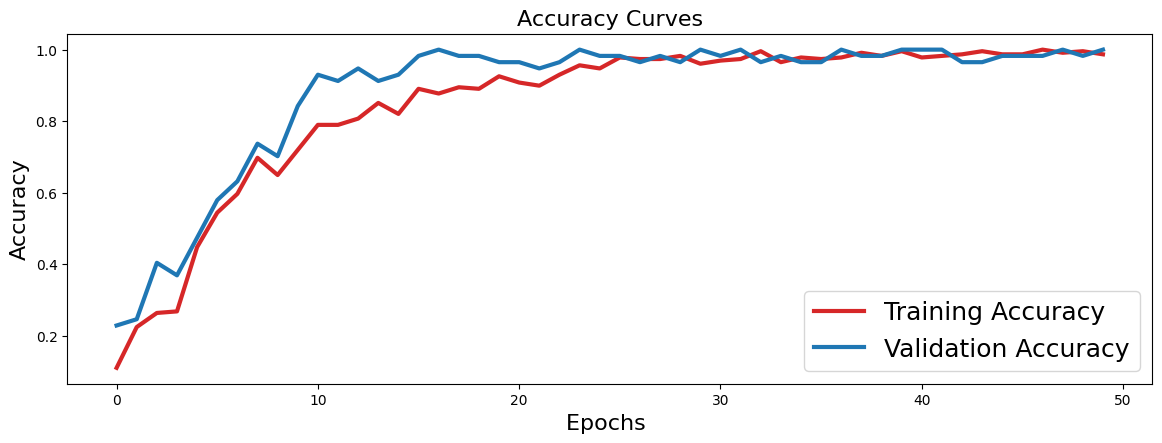

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0525
Test loss: 0.04913003370165825
Test accuracy: 1.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
                        precision    recall  f1-score   support

   Common Reed Bunting       1.00      1.00      1.00         5
Eurasian Collared Dove       1.00      1.00      1.00         8
  European Turtle Dove       1.00      1.00      1.00         4
                  Rook       1.00      1.00      1.00         4
           Song Thrush       1.00      1.00      1.00         6
    Spotted Flycatcher       1.00      1.00      1.00         1
            Tree Pipit       1.00      1.00      1.00         8
            Willow Tit       1.00      1.00      1.00         8
        Wood Sandpiper       1.00      1.00      1.00         6
          Wood Warbler       1.00      1.00      1.00         7

              accuracy                           1.00        57
             macro avg       1.00      1.00      1.00        57
      

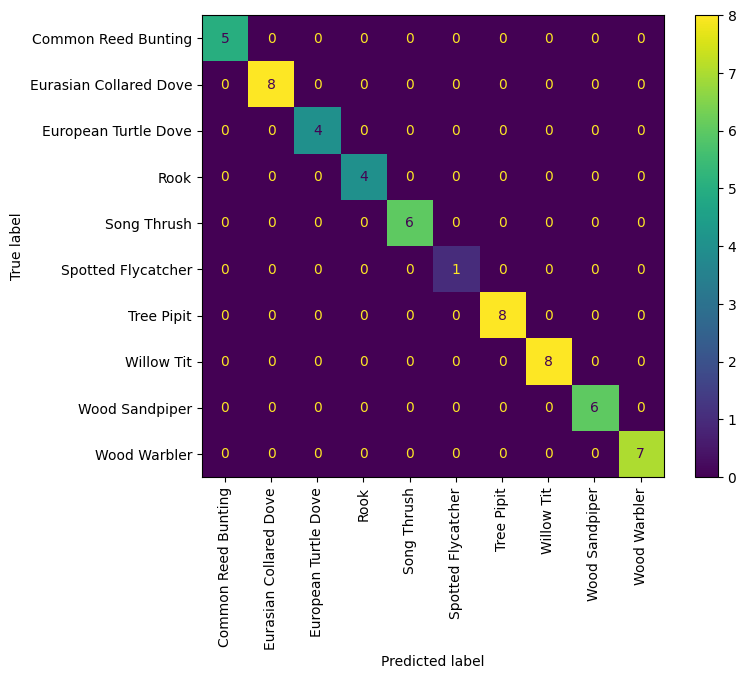

In [39]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# get accuracy score for the model
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Display precision,f1 score,recall scores
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

print(classification_report(y_pred, y_true))

classes

import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
labels_vertical = "\n".join(classes)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
cm_display.plot(ax=ax)
# Rotate the x-axis labels to make them vertical
plt.xticks(rotation=90)
plt.show()

model_name = "birdSoundClassifier.h5"
model.save(model_name)